In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import psColor, bwLabel
import os

TRAIN_DIR = os.listdir(path='../data/treino')
DATA = [cv2.imread('../data/treino/' + image_path) for image_path in TRAIN_DIR]
TARGETS = [7, 5, 3, 4, 2, 4, 0, 3, 4, 4, 4, 1, 4, 3]

In [9]:
def showImages(imageArray, titles):
    for i, img in enumerate(imageArray):
        cv2.imshow(titles[i], img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [10]:
#1. Leitura de imagens

image= DATA[8]

showImages([image], ["Imagem Original"])

In [ ]:
#2. Binarização 

#Tirar background
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
blue_low= np.array([100, 100, 0])
blue_high= np.array([140, 255, 255])
background_mask= cv2.inRange(image_hsv, blue_low, blue_high)
inverted_mask= 255 - background_mask
image_objects= cv2.bitwise_and(image, image, mask=inverted_mask)

# cv2.imshow('Mask', inverted_mask)

image_gs= cv2.cvtColor(image_objects, cv2.COLOR_BGR2GRAY)

thresh, tresh_img= cv2.threshold(image_gs, 150, 255, cv2.THRESH_BINARY)

aux_1= cv2.cvtColor(tresh_img, cv2.COLOR_GRAY2BGR)

showImages([image_objects, aux_1], ["Imagem sem background", "Imagem Binarizada"])

In [13]:
cv2.imshow('test', cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

cv2.waitKey(0)
cv2.destroyAllWindows()

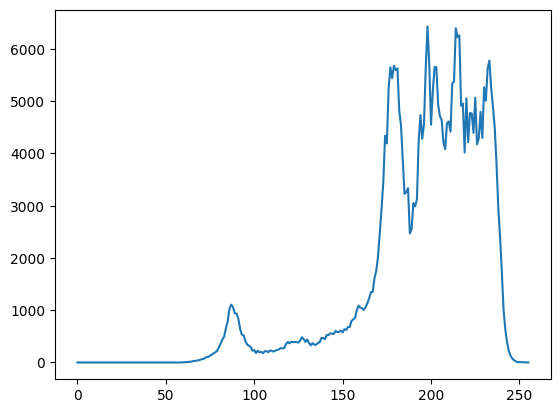

In [19]:
image = DATA[8]

image[:,:,0]
hist = cv2.calcHist([image], [0], None, [256], [0, 256])
plt.plot(hist)